# Well-Stirred Reactor

This Jupyter Notebook was written by Dan Haworth. It was adapted from the Notebook "stirred_reactor.ipynb" at https://github.com/Cantera/cantera-jupyter/tree/master/reactors. It is intended as a tutorial to be used in parallel with Chapter 6 of the book "An Introduction to Combustion: Concepts and Applications" by Stephen R. Turns and Daniel C. Haworth. That book is referred to as "Turns 4th ed." throughout this Notebook.

This Notebook was last updated by Dan Haworth on 2 March 2020.

The objective of this tutorial is to show how to simulate a well-stirred reactor (WSR) using Cantera, and to illustrate basic WSR behavior. More information on [Cantera zero-dimensional reactor networks](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/zerodim.html) is provided. The tutorial also provides an example of how one can import external data (here, experimental data) into Cantera, and plot a quantitative comparison between Cantera model results and experimental data. We will use the thermodynamic properties and reaction mechanism that are included in galway.cti.

The files "galway.cti" (reaction mechanism input data file, provided with this Notebook) and "zhangExpData.csv" (experimental data in Excel-compatible .csv format) must be placed in a folder or directory named "data" that is immediately below the folder or directory from which you have opened this Notebook. And the files "Figure6p5_Turns4thed.png" and "CanteraWSRModel.png" (image files) must be placed in a folder or directory named "images" that is immediately below the folder or directory from which you have opened this Notebook. If you downloaded the .zip file that contains all of the tutorial Notebooks, the appropriate folder and file structure should be in place. The .cti and .csv files are also available at https://github.com/Cantera/cantera-jupyter/tree/master/reactors/data.

The reader should be familiar with the material in the previous tutorial Notebook (6_2_HCCI_engine) before working through this Notebook.

## 1. Physical description

A schematic of a *well-stirred reactor* (WSR) is shown below; this is Figure 6.5 of Turns 4th ed. (Note: For the figure to display properly, the file "Figure6p5_Turns4thed.png" must be placed in a folder or directory named "images" that is immediately below the folder or directory from which you have opened this Notebook. If you downloaded the .zip file that contains all of the tutorial Notebooks, the appropriate folder and file structure should be in place.)

The reactor is stirred (by a fan, for example) with sufficient intensity to ensure that the mixture temperature and composition in the reactor are spatially homogeneous. This configuration is also referred to as a *perfectly stirred reactor* (PSR), a *continuously stirred tank reactor* (CSTR), a *jet-stirred reactor* (JSR), or a *Longwell reactor*.

The reactor temperature, pressure, volume, and composition (in terms of species $i$ mass fractions) are denoted as $T$, $P$, $V$, and $Y_i$, respectively. The reactor volume $V$ is fixed. In general, the other quantities can vary in time, although here we will consider the case where the pressure is constant.

In contrast to the fixed-mass batch reactors considered earlier, this is an open system. A gas mixture with a prescribed temperature (or enthalpy), pressure, and composition enters the reactor at the inlet with mass flow rate $\dot{m}$. And a gas mixture whose temperature (or enthalpy), pressure, and composition correspond to the instantanous values in the reactor exits the reactor at the outlet. In steady-state operation (the case of interest here), the reactor temperature, pressure, and composition are constant in time, and the the outlet mass flow rate is equal to the inlet mass flow rate $ \dot{m}$.

<img src="images/Figure6p5_Turns4thed.png" alt="Schematic of a well-stirred reactor" style="width: 300px;"/>

A key quantity in understanding WSR behavior is the *residence time* $\tau$. This is the average time that a parcel of the gas mixture spends in the reactor. The residence time is defined as:

\begin{equation*}
\tau = \frac{m}{\dot{m}}
\end{equation*}

where $m$ is the instantaneous mass of the gas mixture in the reactor (which is constant, in the case of steady-state operation).

The goal in modeling a WSR is to compute the thermochemical state of the mixture in the reactor (its temperature, pressure, and composition), given the thermochemical state of the inlet mixture and the residence time $\tau$ (or equivalently, the mass flow rate $\dot{m}$).

Two different scenarios are considered in this Notebook. In the first scenario, the reactor temperature is given and is equal to the inlet temperature. In that case, it is not necessary to solve an energy equation. In the second scenario, the reactor temperature is computed as part of the solution, assuming no heat transfer between the mixture in the reactor and its surroundings (adiabatic system). 

In the second scenario, it is necessary to solve an energy equation, and the behavior of the system as $\tau$ is varied (for a given inlet thermochemical state) is of particular interest: 

* In the limit as $\tau \rightarrow \infty $, the outlet temperature and composition can be expected to reach chemical equilibrium: specifically, the constant-pressure, constant-enthalpy equilibrium corresponding to the inlet thermochemical state, since this is a constant-pressure adiabatic system. 

* In the limit as $\tau \rightarrow 0$, the outlet temperature and composition can be expected to remain at the inlet values, since there is insufficient time for chemical reactions to occur.

* For intermediate values of $\tau$, the outlet temperature and composition can be expected to lie somewhere between the inlet values and the equilibrium values. For example, consider a case where the inlet conditions correspond to a fuel-oxidizer reactant mixture at a specified temperature, pressure, and equivalence ratio. Then starting with a residence time that is sufficiently long that the outlet thermochemical state corresponds to chemical equilibrium (with the equilibrium temperature being greater than inlet temperature), the outlet temperature should decrease with decreasing residence time. However, the outlet temperature typically will not decrease smoothly toward the inlet temperature as the residence time is decreased toward zero. At a particular critical value of the residence time, whose value depends on the inlet thermochemical state, the outlet temperature will suddenly drop to the inlet temperature and the outlet composition will be the same as the inlet condition. For residence times smaller than the critical residence time, there is insufficient time for the chemical reactions needed to break down the fuel and oxidizer to take place. This critical residence time is referred to as the reactor *blowout* residence time.

Because the WSR is very sensitive to chemical kinetics rates, and the outlet temperature and composition can be varied over a wide range simply by varying the residence time, and blowout occurs at a very specific value of the residence time that is determined by the inlet thermochemical state, the WSR is a useful configuration for exploring chemical kinetics and for developing and validating reaction mechanisms. See Chapter 6 of Turns 4th ed. for further discussion.

## 2. Governing equations and Cantera model setup: Fixed-reactor-temperature case

The equations governing the evolution of a constant-pressure WSR in steady-state operation can be found in Chapter 6 of Turns 4th ed. For steady-state operation, these equations can be written as a sytem of coupled nonlinear *algebraic* equations (versus ordinary differential equations). Here we consider cases where the reactor mixture temperature is given, and is equal to the inlet mixture temperature. This implies that the reactor must be nonadiabatic. In Section 4 below, we will consider a case where we solve for the reactor temperature as part of the solution, and the reactor is taken to be adiabatic.

As was the case for the fixed-mass batch reactors considered earlier, we do not need to explicitly provide the system of equations that are to be solved to Cantera. However, because a WSR has an inlet and an outlet, the setup is more involved than for the fixed-mass batch reactors that have been considered up to this point. Moreover, while we are interested in steady-state reactor operation, in Cantera we will perform an unsteady simulation starting from a given initial condition in the reactor, and we will integrate in time until steady-state is reached. The choice of initial conditions is arbitrary in principle, but in practice, the closer the assumed initial conditions are to the final steady-state solution, the lower the computational time will be.

A schematic of the configuration that we will use to represent a WSR in Cantera is shown below. (Note: For the figure to display properly, the file "CanteraWSRModel.png" must be placed in a folder or directory named "images" that is immediately below the folder or directory from which you have opened this Notebook. If you downloaded the .zip file that contains all of the tutorial Notebooks, the appropriate folder and file structure should be in place.)

<img src="images/CanteraWSRModel.png" alt="Schematic of a WSR in Cantera" style="width: 750px;"/>

The WSR itself is modeled using a Cantera [`Reactor()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/zerodim.html#reactor) (specifically, an [`IdealGasReactor()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/zerodim.html#idealgasreactor)) object, as we have done in previous tutorial Notebooks. In addition to the reactor itself, on the inlet side we define an upstream reservoir using a Cantera [`Reservoir()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/zerodim.html#reservoir) object that contains a gas mixture at the prescribed inlet state. The mass flow rate from the upstream reservoir into the reactor is maintained at the desired value using a Cantera [`MassFlowController()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/zerodim.html#massflowcontroller). Then on the outlet side, we define a second (downstream) `Reservoir()` into which the outlet gas mixture flows. On the outlet side, a pressure regulator (a Cantera [`Valve()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/zerodim.html#valve) object) is used to maintain the reactor at the desired pressure. 

Now let's go ahead and build our WSR model.

In [1]:
# import modules
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# print Cantera version
print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


Here we consider n-heptane/oxygen/helium mixtures, and set up the model to correspond to conditions for which experimental data are available in a [2015 paper by Zhang et al.](http://dx.doi.org/10.1016/j.combustflame.2015.08.001) The reaction mechanism and thermodynamic property data are in galway.cti. This is the same reaction mechanism that was used in the 2015 paper.

In [2]:
# define a gas mixture based on galway.cti
# the file "galway.cti" must be present in subdirectory "data" below the current working directory
gas = ct.Solution('data/galway.cti')



**** WARNING ****
For species OHV, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  53.6206
	Value computed using high-temperature polynomial: 53.5842


**** WARNING ****
For species CHV, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  107.505
	Value computed using high-temperature polynomial: 107.348


There are small discontinuities in the thermodynamic property data at the midpoint temperature Tmid for some species. As in previous tutorial Notebooks, we will ignore these warnings.

In [3]:
# print the number of species and number of reactions in the reaction mechanism.
gas.n_species, gas.n_reactions

(1268, 5336)

The reaction mechanism considers 5336 individual chemical reactions involving 1268 different species, or molecules. In this input data file, upper-case names are used for species. In particular, n-heptane is named "NC7H16" here, as can be seen by scrolling down through the list of species below. There is no NOx chemistry in this reaction mechanism.

In [4]:
# list all species in the reaction mechanism
gas.species()

[<Species AR>,
 <Species N2>,
 <Species HE>,
 <Species H2>,
 <Species H>,
 <Species O2>,
 <Species O>,
 <Species H2O>,
 <Species OH>,
 <Species OHV>,
 <Species H2O2>,
 <Species HO2>,
 <Species CO>,
 <Species CO2>,
 <Species HOCO>,
 <Species CH4>,
 <Species CH3>,
 <Species CH2>,
 <Species CH2(S)>,
 <Species C>,
 <Species CH>,
 <Species CHV>,
 <Species CH3O2H>,
 <Species CH3O2>,
 <Species CH2O2H>,
 <Species CH3OH>,
 <Species CH3O>,
 <Species CH2OH>,
 <Species CH2O>,
 <Species HCO>,
 <Species HCOH>,
 <Species HO2CHO>,
 <Species HOCH2O2H>,
 <Species HOCH2O2>,
 <Species OCH2O2H>,
 <Species HOCH2O>,
 <Species O2CHO>,
 <Species HOCHO>,
 <Species OCHO>,
 <Species C2H6>,
 <Species C2H5>,
 <Species C2H5O2H>,
 <Species C2H5O2>,
 <Species C2H4>,
 <Species C2H3>,
 <Species CHOCHO>,
 <Species C2H3OOH>,
 <Species C2H3OO>,
 <Species CHCHO>,
 <Species C2H2>,
 <Species C2H>,
 <Species H2CC>,
 <Species C2H5OH>,
 <Species C2H5O>,
 <Species PC2H4OH>,
 <Species SC2H4OH>,
 <Species O2C2H4OH>,
 <Species C2H4O

In [5]:
# specify the inlet temperature, pressure, and composition
# this corresponds to one of the conditions that was explored experimentally in the paper referenced earlier
# note that the inlet gas mixture contains mostly helium, which acts as an inert diluent
T_in = 925.                # (K)
P_in = 1.046138*ct.one_atm # (Pa) - this corresponds to the inlet pressure of 1.06 bar used in the experiments
X_in = {'NC7H16': 0.005, 'O2': 0.0275, 'HE': 0.9675}
gas.TPX = T_in, P_in, X_in

# print the current gas state, which corresponds to the reactor inlet state
gas()


  gas:

       temperature             925  K
          pressure          106000  Pa
           density       0.0724067  kg/m^3
  mean mol. weight          5.2535  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      2.4949e+06        1.311e+07     J
   internal energy      1.0309e+06        5.416e+06     J
           entropy           29701         1.56e+05     J/K
    Gibbs function     -2.4979e+07       -1.312e+08     J
 heat capacity c_p          4360.1        2.291e+04     J/K
 heat capacity c_v          2777.4        1.459e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                HE         0.9675          0.73713          -16.297
                O2         0.0275         0.167501         -29.9058
            NC7H16          0.005        0.0953688         -94.5625
     [+1265 minor]          

In [6]:
# specify key reactor quantities to correspond to those used in the experiments
residenceTime   = 2.              # (s)
reactorVolume   = 30.5*(1.e-2)**3 # (m^3) - this is a 30.5 cc reactor
reactorPressure = P_in            # (Pa)

In [7]:
# specify parameters for the outlet pressure regulator

# the pressure regulator (a "Valve" in Cantera) K-factor, or "conductance," relates the pressure drop across the valve
#   to the mass flow rate through the valve
pressureValveCoefficient = 0.01

# we will monitor the reactor pressure, to make sure that the pressure remains sufficiently close to the desired value
# a warning will be printed if the pressure rise exceeds the specified tolerance
# if that happens, the value of pressureValveCoefficient can be changed to control the pressure more tightly
maxPressureRiseAllowed = 0.01

In [8]:
# define the upstream reservoir
# recall that the gas mixture "gas" is currently set to the inlet state
fuelAirMixtureTank = ct.Reservoir(gas)

# define the downstream reservoir
# it is also initialized to the current state of the gas mixture "gas"
exhaust = ct.Reservoir(gas)

# define the reactor to be an ideal-gas constant-volume reactor with the desired volume,
#   and fill it with the gas mixture "gas" (which is currently set to the desired inlet state)
# we do not need to solve the energy equation, since here the reactor temperature is maintained to be equal to
#   the inlet temperature - this implies that the system must be nonadiabatic
stirredReactor = ct.IdealGasReactor(gas, energy='off', volume=reactorVolume)

# define the inlet-side mass flow controller, which is between the upstream reservoir and the reactor itself
# note that the mass flow rate is set to be equal to the current reactor mass divided by the specified residence time
massFlowController = ct.MassFlowController(upstream=fuelAirMixtureTank,
                                           downstream=stirredReactor,
                                           mdot=stirredReactor.mass/residenceTime)

# define the outlet-side pressure regulator (valve), which is between the reactor itself and the downstream reservoir
pressureRegulator = ct.Valve(upstream=stirredReactor,
                             downstream=exhaust,
                             K=pressureValveCoefficient)

# define the reactor network
reactorNetwork = ct.ReactorNet([stirredReactor])

In [9]:
# let's see what Cantera's  "MassFlowController" class does
help(ct.MassFlowController)

Help on class MassFlowController in module cantera._cantera:

class MassFlowController(FlowDevice)
 |  MassFlowController(upstream, downstream, name=None, *, mdot=None)
 |  
 |  A mass flow controller maintains a specified mass
 |  flow rate independent of upstream and downstream conditions. The equation
 |  used to compute the mass flow rate is
 |  
 |  .. math::
 |  
 |      \dot m = \max(\dot m_0, 0.0),
 |  
 |  where :math:`\dot m_0` is either a constant value or a function of time.
 |  Note that if :math:`\dot m_0 < 0`, the mass flow rate will be set to zero,
 |  since reversal of the flow direction is not allowed.
 |  
 |  Unlike a real mass flow controller, a MassFlowController object will
 |  maintain the flow even if the downstream pressure is greater than the
 |  upstream pressure.  This allows simple implementation of loops, in which
 |  exhaust gas from a reactor is fed back into it through an inlet. But note
 |  that this capability should be used with caution, since no ac

In [10]:
# let's see what Cantera's  "Valve" class does
help(ct.Valve)

Help on class Valve in module cantera._cantera:

class Valve(FlowDevice)
 |  Valve(upstream, downstream, name=None, *, K=None)
 |  
 |  In Cantera, a `Valve` is a flow device with mass flow rate that is a
 |  function of the pressure drop across it. The default behavior is linear:
 |  
 |  .. math:: \dot m = K_v*(P_1 - P_2)
 |  
 |  where :math:`K_v` is a constant set by the `set_valve_coeff` method.
 |  Note that :math:`P_1` must be greater than :math:`P_2`; otherwise,
 |  :math:`\dot m = 0`. However, an arbitrary function can also be specified,
 |  such that
 |  
 |  .. math:: \dot m = f(P_1 - P_2)
 |  
 |  where :math:`f` is the arbitrary function that returns the mass flow rate given
 |  a single argument, the pressure differential. See the documentation for the
 |  `set_valve_coeff` method for an example. Note that it is never possible for
 |  the flow to reverse and go from the downstream to the upstream
 |  reactor/reservoir through a line containing a `Valve` object.
 |  
 |  `

In [11]:
# compile a list of all variables for which we will store time-dependent data during the time integration
# here the reactor pressure is added to the list - recall that pressure is not one of the "n_vars" state variables
#   for a constant-volume reactor
# here we put the pressure at the beginning of the list, rather than at the end of the list as we have done in
#   earlier tutorial Notebooks
columnNames = [stirredReactor.component_name(item) for item in range(stirredReactor.n_vars)]
columnNames = ['pressure'] + columnNames

# use the above list to create a DataFrame
timeHistory = pd.DataFrame(columns=columnNames)

In [12]:
# specify the end time for the time integration
# this should be long enough for the system to reach steady state - that will be verified below
# in general, prior experience and/or trial-and-error may be need to find an appropriate value
# alternatively, one could use "advance_to_steady_state" rather than "step" to perform the time integration;
#   see https://cantera.org/documentation/docs-2.4/sphinx/html/cython/zerodim.html#reactor-networks
maxSimulationTime = 20. # (s)

In [13]:
# in the course of the time integration below, numpy's "hstack" function is used to define a row vector
#   that holds the current state of the reactor gas mixture
# this is an alternative to the "concatenate" function that we have used in earlier tutorial Notebooks
help(np.hstack)

Help on function hstack in module numpy.core.shape_base:

hstack(tup)
    Stack arrays in sequence horizontally (column wise).
    
    This is equivalent to concatenation along the second axis, except for 1-D
    arrays where it concatenates along the first axis. Rebuilds arrays divided
    by `hsplit`.
    
    This function makes most sense for arrays with up to 3 dimensions. For
    instance, for pixel-data with a height (first axis), width (second axis),
    and r/g/b channels (third axis). The functions `concatenate`, `stack` and
    `block` provide more general stacking and concatenation operations.
    
    Parameters
    ----------
    tup : sequence of ndarrays
        The arrays must have the same shape along all but the second axis,
        except 1-D arrays which can be any length.
    
    Returns
    -------
    stacked : ndarray
        The array formed by stacking the given arrays.
    
    See Also
    --------
    stack : Join a sequence of arrays along a new axis.
 

Now perform the time integration. Be patient: this will take a minute or two, depending on your computer.

In [14]:
# start the timer used to monitor computer time needed
ctim0 = time.time()

# during the time integration, the mass flow rate is held constant as the mass of the gas mixture in the reactor
#   varies as a function of time
# the residence time (as defined by the instantaneous reactor mass and inlet mass flow rate) therefore varies over
#   the course of the time integration

# initialize the simulation time and counter to zero
t       = 0.
counter = 0

# perform the time integration
# we print some output to the screen over the course of the time integration, to monitor its progress
while t < maxSimulationTime:
    t = reactorNetwork.step()

# save the reactor state once every 50 time steps
    if(counter%50 == 0):
# recall that pressure and species mole fractions are not attributes of the constant-volume reactor -
#   the composition is in terms of mass fractions in the standard reactor state variables
# mixture pressure and species mole fractions are accessed using "thermo"
        state = np.hstack([stirredReactor.thermo.P, stirredReactor.mass, 
                   stirredReactor.volume, stirredReactor.T, stirredReactor.thermo.X])
        
        timeHistory.loc[t] = state
        print(t,stirredReactor.T,stirredReactor.thermo.P,stirredReactor.mass,massFlowController.mdot(t))
        
    counter += 1

# stop the timer used to monitor the computer time needed
ctim1 = time.time()
ctime = ctim1 - ctim0

# print the computer time required and the number of computational time steps
print('Simulation Took {:3.2f} s to compute, with {} steps'.format(ctime, counter))

# check that the difference between the maximum and minimum pressure over the course of the time integration,
#   divided by the desired reactor pressure, did not exceed the specified value of "maxPressureRiseAllowed"
pressureDifferential = timeHistory['pressure'].max()-timeHistory['pressure'].min()
if(abs(pressureDifferential/reactorPressure) > maxPressureRiseAllowed):
    print("WARNING: Non-trivial pressure rise in the reactor. Adjust K value in valve, and rerun")

1.0495790597866916e-12 925.0 105999.93285005561 2.208403865036804e-06 1.1042019325178228e-06
1.0848581476078166e-05 925.0 105999.93296043636 2.208403865765405e-06 1.1042019325178228e-06
0.0002793615439054705 925.0 105999.9329604433 2.2084038108731736e-06 1.1042019325178228e-06
0.005175475493272472 925.0 105999.93296048252 2.2084016834039993e-06 1.1042019325178228e-06
0.028918407704532235 925.0 105999.93296066299 2.2083667323219707e-06 1.1042019325178228e-06
0.055941908396604394 925.0 105999.93296093572 2.2082657652276968e-06 1.1042019325178228e-06
0.0806393578554324 925.0 105999.93296123006 2.208102883793925e-06 1.1042019325178228e-06
0.13200252568512097 925.0 105999.93296192333 2.207511561410097e-06 1.1042019325178228e-06
0.20786489687160378 925.0 105999.93296291676 2.2059837379197456e-06 1.1042019325178228e-06
0.29991052174254185 925.0 105999.9329637285 2.2032684383158995e-06 1.1042019325178228e-06
0.3844510016427723 925.0 105999.93296398666 2.2003299834444873e-06 1.1042019325178228e

Plot the mole fraction of CO to see if the system has reached steady state. If not, go back and increase the value of maxSimulationTime, and rerun.

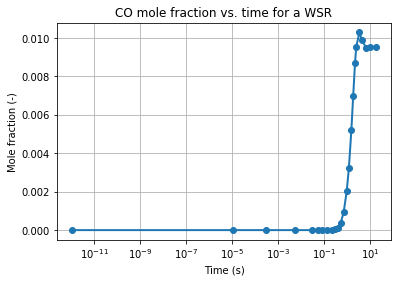

In [15]:
# plot CO mole fraction as a function of time, using a log axis for time
fig, ax = plt.subplots()
ax.semilogx(timeHistory.index, timeHistory['CO'], '-o', label='CO', lw=2)
ax.set(xlabel='Time (s)',
       ylabel='Mole fraction (-)',
       title ='CO mole fraction vs. time for a WSR')
#ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("CO_vs_t_WSR.pdf")

It appears that CO, at least, has reached steady state.

## 3. Reactor composition versus temperature: Comparison with experiment

Next, we simulate a range of inlet temperatures for which experimental data were reported in the [2015 paper by Zhang et al.](http://dx.doi.org/10.1016/j.combustflame.2015.08.001) (Zhang et al., Combustion and Flame 162:4194-4207, 2015), and compare the steady-state simulation results with the experimental measurements.

In [16]:
# read experimental data into a Pandas DataFrame
# the Excel file "zhangExpData.csv" must be in subdirectory "data" under the current working directory
expData = pd.read_csv('data/zhangExpData.csv')

# print the first few rows of experimental data
expData.head()

,T,NC7H16,O2,CO,CO2
0,500,0.00507,0.0293,0.000000,0.000000
1,525,0.00492,0.0286,0.000000,0.000000
2,550,0.00466,0.0285,0.000000,0.000000
3,575,0.00416,0.0263,0.000243,0.000101
4,600,0.00355,0.0233,0.000968,0.000251


In [17]:
# list the inlet temperatures (= reactor temperatures here) for which we will run the WSR simulations
# these should overlap with the values reported in the paper
T = [650., 700., 750., 775., 825., 850., 875., 925., 950., 1075., 1100.]

# create a DataFrame to store the final (steady state) reactor state for all of the above reactor temperatures
# this DataFrame is indexed by temperature (one row per inlet temperature)
tempDependence = pd.DataFrame(columns=timeHistory.columns)
tempDependence.index.name = 'Temperature'

In [18]:
# the inlet conditions and reactor parameters are the same as those used in the example above
# here we repeat the intialization, for completeness
T_in = 925. # (K)
P_in = 1.046138*ct.one_atm # (Pa) - this corresponds to the inlet pressure of 1.06 bar used in the experiments
X_in = {'NC7H16': 0.005, 'O2': 0.0275, 'HE': 0.9675}
gas.TPX = T_in, P_in, X_in

# specify key reactor quantities to correspond to those used in the experiments
residenceTime   = 2.              # (s)
reactorVolume   = 30.5*(1.e-2)**3 # (m^3) - this is a 30.5 cc reactor
reactorPressure = P_in            # (Pa)

# specify parameters for the outlet pressure regulator
pressureValveCoefficient = 0.01
maxPressureRiseAllowed   = 0.01

Now run a WSR simulation for each inlet temperature. Be patient. This will take several minutes, depending on your computer.

In [19]:
# initialize the steady-state mole fractions to be equal to the inlet mole fractions
X_ss = X_in

# loop over reactor temperatures

##### top of loop over inlet temperatures (= reactor temperature) #####
for temperature in T:
    
# reinitialize the gas in the reactor to the desired inlet thermochemical state
    reactorTemperature = temperature # (K)

    gas.TPX = reactorTemperature, reactorPressure, X_in

# reinitialize the DataFrame used to hold the time evolution of the system
    timeHistory = pd.DataFrame(columns=columnNames)
    
# reinitialize the upstream and downstream reservoirs
    fuelAirMixtureTank = ct.Reservoir(gas)
    exhaust            = ct.Reservoir(gas)
    
# to speed up the simulation, the inital reactor composition is set to be equal to the steady-state composition
#   from the end of the previous simulation
    gas.TPX        = reactorTemperature, reactorPressure, X_ss
    stirredReactor = ct.IdealGasReactor(gas, energy='off', volume=reactorVolume)
    
# reinitialize the inlet mass-flow controller and outlet pressure regulator
    massFlowController = ct.MassFlowController(upstream=fuelAirMixtureTank,
                                               downstream=stirredReactor,
                                               mdot=stirredReactor.mass/residenceTime)
    pressureRegulator = ct.Valve(upstream=stirredReactor, 
                                 downstream=exhaust, 
                                 K=pressureValveCoefficient)
    
# reinitialize the reactor network
    reactorNetwork = ct.ReactorNet([stirredReactor])
    
# perform the time integration for the current inlet temperature (= reactor temperature),
#   and monitor the computer time required
    ctim0   = time.time()
    t       = 0.
    counter = 0
    while t < maxSimulationTime:
        t = reactorNetwork.step()

# print some output as the time-integration proceeds, to monitor progress
        if(counter%50 == 0):
            print(t,stirredReactor.T,stirredReactor.thermo.P,stirredReactor.mass,massFlowController.mdot(t))
        
        counter += 1

# capture the final reactor state for the current inlet temperature (= reactor temperature)
# note again how the pressure and species mole fractions are included
    state = np.hstack([stirredReactor.thermo.P, 
                       stirredReactor.mass, 
                       stirredReactor.volume, 
                       stirredReactor.T, 
                       stirredReactor.thermo.X])

# calculate the computer time required
    ctim1 = time.time()
    ctime = ctim1 - ctim0
    print('Simulation at T={} K took {:3.2f}s to compute'.format(temperature, ctime))

# save the final (steady state) composition, in terms of species mole fractions
    X_ss = stirredReactor.thermo.X
    
# store the steady-state reactor state in the DataFrame defined earlier that indexes by temperature
    tempDependence.loc[temperature] = state
    
# check that the difference between the maximum and minimum pressure over the course of the time integration,
#   divided by the desired reactor pressure, did not exceed the specified value of "maxPressureRiseAllowed"
    pressureDifferential = timeHistory['pressure'].max()-timeHistory['pressure'].min()
    if(abs(pressureDifferential/reactorPressure) > maxPressureRiseAllowed):
        print("WARNING: Non-trivial pressure rise in the reactor. Adjust K value in valve, and rerun")

##### end of loop over inlet temperatures #####    

1.1803936693052587e-08 650.0 105999.93297559119 3.1427285808896886e-06 1.5713642885830553e-06
0.8374710491859839 650.0 105999.9330071383 3.1427285807445283e-06 1.5713642885830553e-06
1.4649405276529404 650.0 105999.93300713733 3.1427285059317235e-06 1.5713642885830553e-06
1.5633693838065097 650.0 105999.93300713519 3.142728421497416e-06 1.5713642885830553e-06
1.6311514431281806 650.0 105999.93300713529 3.142728305173552e-06 1.5713642885830553e-06
1.7472876465027063 650.0 105999.93300713575 3.1427278401534076e-06 1.5713642885830553e-06
1.8192520333941502 650.0 105999.93300713766 3.1427272034360167e-06 1.5713642885830553e-06
1.8779530766315602 650.0 105999.93300713836 3.1427263317865903e-06 1.5713642885830553e-06
1.9656543259172217 650.0 105999.93300713973 3.1427241342683965e-06 1.5713642885830553e-06
2.084217591558391 650.0 105999.93300714275 3.142718645646991e-06 1.5713642885830553e-06
2.2575617495888056 650.0 105999.93300714935 3.142702655817862e-06 1.5713642885830553e-06
2.3764379673

8.018786390758892 825.0 105999.93297382386 2.4714808449081175e-06 1.2379795925173996e-06
9.93380092770645 825.0 105999.93297381281 2.471095487182644e-06 1.2379795925173996e-06
16.289421158856587 825.0 105999.93297379992 2.4706867386069464e-06 1.2379795925173996e-06
Simulation at T=825.0 K took 59.43s to compute
7.238433203970287e-12 850.0 105999.93285038731 2.3979771751770825e-06 1.1989885875842159e-06
2.8561771692661197e-07 850.0 105999.93297121396 2.397977173948593e-06 1.1989885875842159e-06
7.94230344373219e-06 850.0 105999.93297045551 2.397977112237008e-06 1.1989885875842159e-06
5.2481768493113704e-05 850.0 105999.93297011383 2.3979769851670917e-06 1.1989885875842159e-06
0.00032313196933181235 850.0 105999.9329701249 2.39797639236339e-06 1.1989885875842159e-06
0.0026417866597685073 850.0 105999.93297019578 2.3979701935571935e-06 1.1989885875842159e-06
0.011731925592309423 850.0 105999.93297025765 2.3979395058536796e-06 1.1989885875842159e-06
0.04002219472249281 850.0 105999.9329702

0.5003746723908572 1075.0 105999.932943921 1.8497347483798666e-06 9.317165566471122e-07
0.6449654042445084 1075.0 105999.93294351547 1.8489815962457231e-06 9.317165566471122e-07
1.0628058359759631 1075.0 105999.93294320704 1.8484127121582163e-06 9.317165566471122e-07
1.771045797050858 1075.0 105999.93294317246 1.848347896970398e-06 9.317165566471122e-07
3.648422288563247 1075.0 105999.93294316834 1.8483914524507633e-06 9.317165566471122e-07
7.87089093649733 1075.0 105999.93294317125 1.8484622261874998e-06 9.317165566471122e-07
17.271602076203365 1075.0 105999.93294317165 1.8484710931906157e-06 9.317165566471122e-07
Simulation at T=1075.0 K took 75.33s to compute
9.131555976964842e-13 1100.0 105999.93285005039 1.8064604130753928e-06 9.032302065372842e-07
4.2770471056470396e-08 1100.0 105999.93294378353 1.8064604131526659e-06 9.032302065372842e-07
1.936019714275478e-06 1100.0 105999.93294229865 1.8064603675449227e-06 9.032302065372842e-07
1.8830006690027222e-05 1100.0 105999.93294155945 

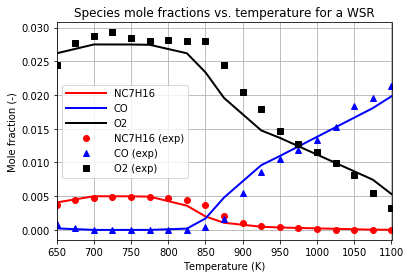

In [20]:
# plot the computed and measured steady-state reactor composition as functions of inlet temperature
fig, ax = plt.subplots()
ax.plot(tempDependence.index, tempDependence['NC7H16'], 'r-', label='NC7H16',      lw=2)
ax.plot(tempDependence.index, tempDependence['CO'],     'b-', label='CO',          lw=2)
ax.plot(tempDependence.index, tempDependence['O2'],     'k-', label='O2',          lw=2)
ax.plot(expData['T'],         expData['NC7H16'],        'ro', label='NC7H16 (exp)'     )
ax.plot(expData['T'],         expData['CO'],            'b^', label='CO (exp)'         )
ax.plot(expData['T'],         expData['O2'],            'ks', label='O2 (exp)'         )

ax.set(xlim=(650.,1100.),
       xlabel='Temperature (K)',
       ylabel='Mole fraction (-)',
       title ='Species mole fractions vs. temperature for a WSR')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("X_vs_T_WSR.pdf")

For low reactor temperatures, the outlet composition remains close to the inlet composition: there is little conversion from reactants to products. The n-heptane and O2 mole fractions decrease with increasing reactor temperature, while CO mole fraction increases with increasing reactor temperature. The Cantera model captures the experimentally observed behavior. At still higher temperatures, presumably the CO mole fraction would decrease again as the conversion to CO2 becomes more complete.

## 4. Reactor blowout

We now consider a WSR into which flows a more conventional hydrocarbon fuel-air reactant mixture. Here a constant-pressure adiabatic reactor is simulated. In contrast to the previous two sections, the reactor temperature is not necessarily equal to the inlet temperature here. So in this case, we need to solve an energy equation in addition to the species equations.

To explore blowout, we perform simulations over a range of residence times. As for the previous example, it is actually the inlet mass flow rate that is held constant as the system is integrated in time from its initial state to its final steady state for each value of the residence time.

To speed up the simulations (at least, for values of the residence time that are longer than the blowout time), the initial reactor temperature and composition are set to the constant-pressure, constant-enthalpy equilibrium values corresponding to the given inlet condition.

We start again from the beginning (by defining the gas mixture), for completeness.

In [21]:
# define the gas mixture
gas = ct.Solution('data/galway.cti')



**** WARNING ****
For species OHV, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  53.6206
	Value computed using high-temperature polynomial: 53.5842


**** WARNING ****
For species CHV, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  107.505
	Value computed using high-temperature polynomial: 107.348


In [22]:
# prescribe the reactor inlet conditions
# here a stoichiometric n-heptane/air mixture is considered
T_in = 300.
P_in = ct.one_atm
X_in = {'NC7H16': 1.0, 'O2': 11.0, 'N2': 3.76*11.0}

# set the gas mixture thermochemical state to correspond to the the reactor inlet state
gas.TPX = T_in, P_in, X_in

# compute the constant-pressure adiabatic equilibrium state corresponding to the presribed inlet state
# we will use this as the initial condition for the time integration in the reactor
gas.equilibrate('HP')

T_eq = gas.T
P_eq = gas.P
X_eq = gas.X

T_eq, P_eq

(2280.483612856816, 101324.99999999999)

In [23]:
# specify the reactor volume
# here the volume is 100 cc
reactorVolume = 100.*(1.e-2)**3 # (m^3)

# specify the reactor pressure
reactorPressure = P_in

# specify an initial value for the residence time
# this will be reset later
residenceTime = 1.0 # (s)

# specify the end time for the time integration
# note that the value is much smaller than the value used in the previous example
# here we have an undiluted, stoichiometric inlet mixture
maxSimulationTime = 1.0 # (s)

# define the upstream reservoir to correspond to the given inlet conditions
gas.TPX            = T_in, P_in, X_in
fuelAirMixtureTank = ct.Reservoir(gas)

# define the WSR to be a constant-volume ideal-gas reactor, initially at equilibrium conditions corresponding to
#   the given inlet reactant mixture
# here we need to solve the energy equation
gas.TPX        = T_eq, P_eq, X_eq
stirredReactor = ct.IdealGasReactor(gas, energy='on', volume=reactorVolume)

# define the downstream (outlet) reservoir to correspond to the reactor state
exhaust = ct.Reservoir(gas)

# specify the pressure valve parameters
pressureValveCoefficient = 0.01
maxPressureRiseAllowed   = 0.01

# define the reactor network
massFlowController = ct.MassFlowController(upstream=fuelAirMixtureTank,
                                           downstream=stirredReactor,
                                           mdot=stirredReactor.mass/residenceTime)

pressureRegulator = ct.Valve(upstream=stirredReactor, 
                             downstream=exhaust, 
                             K=pressureValveCoefficient)

reactorNetwork = ct.ReactorNet([stirredReactor])

# compile a list of all variables for which we will store time-dependent data
columnNames = [stirredReactor.component_name(item) for item in range(stirredReactor.n_vars)]
columnNames = ['pressure'] + columnNames

# create a DataFrame that can be used to hold and manipulate the time evolution data
timeHistory = pd.DataFrame(columns=columnNames)

# create a second DataFrame to store the final states for each of the residence times specified below
tauDependence = pd.DataFrame(columns=timeHistory.columns)
tauDependence.index.name = 'res. time'

tauDependence

,pressure,mass,volume,temperature,AR,N2,HE,H2,H,O2,...,O2CCHOOJ,HOCVCCJVO,C5H5OH,C5H5O,C5H4OH,C5H4O,C5H3O,CJVCCVCCVO,CVCCVCCJVO,CJVCCVO
res. time,,,,,,,,,,,,,,,,,,,,,


In [24]:
# specify the residence times for which to compute the steady-state solution
# note that we increase the residence time by a factor of 10 for each successive case
tau = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.10, 1.0, 10.0]

Perform the time integration for each residence time. Be patient. This will take several minutes, depending on your computer.

In [25]:
##### top of loop over residence times #####

for residenceTime in tau:
    
# the inlet conditions are the same for all residence times - there is no need to reset them here
    
# re-initialize the reactor to the equilibrium state corresponding to the inlet conditions
# here the energy equation is to be solved
    gas.TPX        = T_eq, P_eq, X_eq
    stirredReactor = ct.IdealGasReactor(gas, energy='on', volume=reactorVolume)

# re-initialize the outlet reservoir to the initial reactor condition
    exhaust = ct.Reservoir(gas)
    
# re-initialize the reactor network   
    massFlowController = ct.MassFlowController(upstream=fuelAirMixtureTank,
                                               downstream=stirredReactor,
                                               mdot=stirredReactor.mass/residenceTime)
    pressureRegulator = ct.Valve(upstream=stirredReactor, 
                                 downstream=exhaust, 
                                 K=pressureValveCoefficient)
    reactorNetwork = ct.ReactorNet([stirredReactor])
    
# re-initialize the DataFrame used to hold values through the time integration
    timeHistory = pd.DataFrame(columns=columnNames)
    
# advance the system in time, and monitor the computer time required
# it is actually the mass flowrate that is held constant as the system evolves, not the residence time
# the system of nonlinear coupled equations becomes extremely ill-conditioned for residence times
#   that are close to blowout
# for that reason, we stop the time integration if the reactor temperature drops to a value that is less
#   than 1% above the inlet temperature
    ctim0   = time.time()
    t       = 0.
    counter = 0
    while t < maxSimulationTime and stirredReactor.T > 1.01*T_in:
        t = reactorNetwork.step()
        
        if(counter%100 == 0):
# extract the state of the reactor
            state = np.hstack([stirredReactor.thermo.P, stirredReactor.mass, 
                               stirredReactor.volume, stirredReactor.T, stirredReactor.thermo.X])
        
# update the dataframe
            timeHistory.loc[t] = state
            
# print some output
            print(t,stirredReactor.mass,stirredReactor.T,massFlowController.mdot(t))
        
        counter += 1

# final state - we want mole fractions instead of mass fractions
    state = np.hstack([stirredReactor.thermo.P, 
                       stirredReactor.mass, 
                       stirredReactor.volume, 
                       stirredReactor.T, 
                       stirredReactor.thermo.X])

    ctim1 = time.time()
    ctime = ctim1 - ctim0
    print('Simulation at tau={} s took {:3.2f}s to compute'.format(residenceTime, ctime))
       
# store the final result in the dataframe that indexes by residence time
    tauDependence.loc[residenceTime] = state
    
# check that the difference between the maximum and minimum pressure over the course of the time integration,
#   divided by the desired reactor pressure, did not exceed the specified value of "maxPressureRiseAllowed"
    pressureDifferential = timeHistory['pressure'].max()-timeHistory['pressure'].min()
    if(abs(pressureDifferential/reactorPressure) > maxPressureRiseAllowed):
        print("WARNING: Non-trivial pressure rise in the reactor. Adjust K value in valve, and rerun")
    
##### end of loop over residence times #####

1.8893052535148412e-17 1.512598001502242e-05 2280.483612824017 15.125980014736646
2.8939587018174686e-09 1.5169094485868382e-05 2275.3420144711704 15.125980014736646
3.864539810807489e-08 1.566676028133585e-05 2207.5824798492554 15.125980014736646
1.0827080214881936e-07 1.6616556077202444e-05 2082.7145849848703 15.125980014736646
1.8963603206752266e-07 1.7714100923703775e-05 1955.1837247790133 15.125980014736646
3.0121345652760393e-07 1.917549590683403e-05 1809.9886929296183 15.125980014736646
4.631138655467041e-07 2.11861788479726e-05 1645.4134195260317 15.125980014736646
6.705022894189851e-07 2.3613166664834907e-05 1484.8023971326218 15.125980014736646
8.687321616788897e-07 2.583678825362654e-05 1363.7264053381743 15.125980014736646
1.1489690252316029e-06 2.8874403965539925e-05 1227.796899834168 15.125980014736646
1.3414575726608481e-06 3.090325486202534e-05 1151.489937135553 15.125980014736646
1.6321998595963754e-06 3.3890069201303e-05 1055.2114673431347 15.125980014736646
1.9906881

0.0037983712104082768 1.5926481045802922e-05 2143.408518664826 0.0015125980014736645
0.07601035755230216 1.592683958956831e-05 2143.3521960169937 0.0015125980014736645
Simulation at tau=0.01 s took 53.99s to compute
5.974507796428739e-15 1.5125980014737547e-05 2280.483612856712 0.00015125980014736644
3.836347360731771e-07 1.512603348499941e-05 2280.475523936733 0.00015125980014736644
1.376843638136261e-05 1.512771744183731e-05 2280.1917219227926 0.00015125980014736644
0.00016208824717156814 1.5143055333255544e-05 2277.4033113796377 0.00015125980014736644
0.0036828247235070576 1.5306611231668475e-05 2248.025085877108 0.00015125980014736644
0.013099630441488262 1.5329348588784335e-05 2244.0021272172753 0.00015125980014736644
Simulation at tau=0.1 s took 34.77s to compute
1.8893052535148412e-14 1.512598001473693e-05 2280.483612856783 1.5125980014736644e-05
1.9553443948830793e-06 1.5126007314755136e-05 2280.479352582294 1.5125980014736644e-05
6.819499729692861e-05 1.512673362849913e-05 228

For high values of the mass flow rate (low values of the residence time), the reactions cannot keep up with the rate at which fresh reactants are entering the reactor, and the reactor state reverts essentially to the inlet state. This is reactor blowout.

Note the long computational time required for cases where the reactor state is essentially the same as the inlet state (reactor blowout). As the residence time increases, the computational time decreases, because we initialized the reactor to a state corresponding to chemical equilibrium.

For the smallest value of the residence time considered here (highest mass flow rate), the reactor pressure rise exceeded the specified limit. We will not worry about that, since this state corresponds to reactor blowout.

In [26]:
# print the final reactor states for each value of the residence time
tauDependence

,pressure,mass,volume,temperature,AR,N2,HE,H2,H,O2,...,O2CCHOOJ,HOCVCCJVO,C5H5OH,C5H5O,C5H4OH,C5H4O,C5H3O,CJVCCVCCVO,CVCCVCCJVO,CJVCCVO
res. time,,,,,,,,,,,,,,,,,,,,,
0.000001,102822.496581,0.000123,0.0001,302.960912,0.0,0.775028,0.0,0.000012,4.278222e-14,0.205881,...,1.501919e-42,2.976192e-13,1.054550e-10,3.143625e-13,1.482479e-15,1.400403e-10,8.349267e-13,1.611161e-17,1.774105e-11,1.271593e-13
0.000010,101474.743879,0.000122,0.0001,302.989346,0.0,0.774996,0.0,0.000031,5.717678e-17,0.205859,...,3.773094e-43,3.332030e-12,2.289465e-09,1.756439e-14,9.769214e-15,6.066810e-09,2.363556e-11,8.997473e-19,4.815387e-10,5.285003e-14
0.000100,101340.125980,0.000019,0.0001,1762.340772,0.0,0.705574,0.0,0.011368,9.368010e-03,0.036401,...,5.758755e-23,6.624424e-14,6.282396e-08,2.297061e-11,9.034424e-09,2.259715e-07,6.604261e-09,9.535986e-10,1.887238e-11,8.279004e-11
0.001000,101326.512598,0.000017,0.0001,1982.922970,0.0,0.710628,0.0,0.010160,6.645787e-03,0.020636,...,4.219276e-22,2.576026e-15,1.005014e-09,1.865095e-13,1.609983e-09,1.194177e-08,9.883591e-11,1.022657e-11,1.178022e-13,1.222182e-12
0.010000,101325.151260,0.000016,0.0001,2143.352195,0.0,0.719236,0.0,0.006391,2.354279e-03,0.013827,...,7.818814e-22,1.216205e-16,3.169767e-12,6.434887e-16,5.334869e-11,1.889633e-10,4.383441e-13,4.022277e-14,6.860058e-16,6.385847e-15
0.100000,101325.015126,0.000015,0.0001,2243.992812,0.0,0.724762,0.0,0.003870,8.183786e-04,0.009027,...,7.214844e-22,5.287961e-18,1.782314e-14,2.272626e-18,1.564248e-12,2.031556e-12,2.629767e-15,1.496468e-16,7.289631e-18,7.067141e-17
1.000000,101325.001513,0.000015,0.0001,2275.561917,0.0,0.726502,0.0,0.003092,5.164415e-04,0.007398,...,6.117255e-22,3.771129e-19,7.069140e-16,6.486076e-20,1.106639e-13,9.026446e-14,1.073140e-16,4.320797e-18,3.351107e-19,4.623698e-18
10.000000,101325.000151,0.000015,0.0001,2279.970874,0.0,0.726746,0.0,0.002985,4.805362e-04,0.007165,...,5.928879e-22,3.587395e-20,6.207941e-17,5.398428e-21,1.057719e-14,8.027517e-15,9.474692e-18,3.601443e-19,2.994199e-20,4.388387e-19


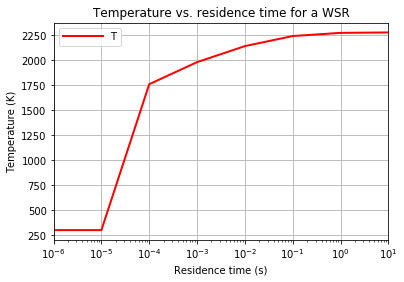

In [27]:
# plot the computed steady-state reactor temperature as a function of residence time
fig, ax = plt.subplots()
ax.semilogx(tauDependence.index, tauDependence['temperature'], 'r-', label='T', lw=2)

ax.set(xlim=(1.e-6,10.),
       xlabel='Residence time (s)',
       ylabel='Temperature (K)',
       title ='Temperature vs. residence time for a WSR')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("T_vs_tau_WSR.pdf")

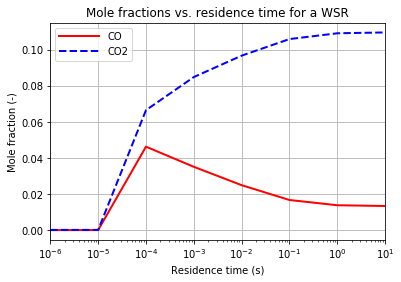

In [28]:
# plot the computed steady-state reactor mole fractions of CO and CO2 as functions of residence time
fig, ax = plt.subplots()
ax.semilogx(tauDependence.index, tauDependence['CO'],  'r-',  label='CO',  lw=2)
ax.semilogx(tauDependence.index, tauDependence['CO2'], 'b--', label='CO2', lw=2)

ax.set(xlim=(1.e-6,10.),
       xlabel='Residence time (s)',
       ylabel='Mole fraction (-)',
       title ='Mole fractions vs. residence time for a WSR')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("X_vs_tau_WSR.pdf")

From these results, it can seen that the blowout residence time for this system is between 10^-5 s and 10^-4 s. This range could be narrowed by performing simulations for intermediate residence time values. For long residence times, the temperature approaches the equilibrium temperature of ~2280.5 K (see above), and the mole fractions of CO and CO2 approach their equilibrium values. As the residence time decreases, but before blowout occurs, the mole fraction of CO increases and the mole fraction of CO2 decreases with decreasing residence time, reflecting increasing departures from equilibrium. Roughly speaking, the state of the mixture for a given value of the residence time in a constant-pressure adiabatic WSR corresponds to the state at some instant in time during the time evolution for a constant-pressure adiabatic fixed-mass reactor.

Further insight into the finite-rate chemical kinetics can be gained by plotting key intermediate species mole (or mass) fractions in the reactor as functions of residence time, especially for residence times close to blowout.